### PSC overexpression example

This notebook prepares a dataset with hundreds of individual overexpression experiments applied to pluripotent stem cells ([Nakatake et al 2020](https://www.sciencedirect.com/science/article/pii/S2211124720306082)). This choice of dataset is meant to be an easy starting point: the time-scale (48 hours) is fairly short-term, the cell state (pluripotency) is well studied,  and the perturbations are numerous (714 genes including 481 TF's). The dataset is also small (~1k samples) so testing/debugging is fast. 

The data contain both microarray and RNA-seq measurements, but these have already been effectively integrated by the authors using a strategy akin to quantile normalization. There are missing values marked -9999, which include genes missing from microarrays and outlying measurements censored by the creators. For now, missing values are being filled in with control gene expression. There are three types of negative control *samples*, labeled "control", "emerald", and "CAG-rtTA35-IH". We use mostly "control". 

Here we tidy the PSC overexpression dataset and carry out a simple exploration in scanpy. (It's not single cell data but scanpy is clearly a useful place to start.) 

In [1]:
import warnings
warnings.filterwarnings('ignore')
import regex as re
import os
import shutil
import sys
import importlib
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import celloracle as co
from scipy.stats import spearmanr as spearmanr
from scipy.stats import pearsonr
import itertools as it
import anndata

from scipy.stats import f_oneway
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.oneway import anova_oneway
from sklearn.metrics import mutual_info_score
import time
from collections import Counter


# local
import importlib
import sys
sys.path.append("setup")
import ingestion
importlib.reload(ingestion)

#      visualization settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

# I prefer to specify the working directory explicitly.
os.chdir("/home/gary/cahan_rotation/perturbation_data")

# Universal
geneAnnotationPath = "setup/gencode.v35.annotation.gtf.gz"       # Downloaded from https://www.gencodegenes.org/human/release_35.html
humanTFPath = "setup/tfList.csv"                                 # Downloaded from http://humantfs.ccbr.utoronto.ca/download.php
humanEpiPath = "setup/epiList.csv"                               # Downloaded from https://epifactors.autosome.org/description 

# Nakatake Specific
rawDataPath = "not_ready/ko_esc/CREST_06162021.txt"
nakatakeSupplemental1Path = "not_ready/ko_esc/nakatakeData.csv"             # https://ars.els-cdn.com/content/image/1-s2.0-S2211124720306082-mmc2.xlsx                                                
nakatakeSupplemental3Path = "not_ready/ko_esc/nakatakeSupplemental3.csv"    # https://ars.els-cdn.com/content/image/1-s2.0-S2211124720306082-mmc4.xlsx
perturbEffectTFOnlyPath = "setup/nakatakeTFOnly.csv"                        # a path to store temp file
perturbEffectFullTranscriptomePath = "setup/nakatakeFullTranscriptome.csv"  # a path to store temp file

finalDataFileFolder = "perturbations/nakatake"
finalDataFilePath   = "perturbations/nakatake/test.h5ad"

### Reshape the data

In [2]:
expression_quantified = pd.read_csv(rawDataPath, 
                                    delimiter="\t",
                                    index_col=0, 
                                    header=0, 
                                    comment = '!') 

In [3]:
gene_metadata   = expression_quantified.iloc[:,-4:]
expression_quantified = expression_quantified.iloc[:, 0:-4].T
sample_metadata = pd.DataFrame(columns = ["perturbation"], 
                               index = expression_quantified.index,
                               data = [re.sub("\..", "", g) for g in expression_quantified.index])

expression_quantified = sc.AnnData(expression_quantified, 
                                   var = gene_metadata,
                                   obs = sample_metadata)
expression_quantified.raw = expression_quantified.copy()

In [4]:
# Document controls with weird names
""" Emerald : Transgene w/ fluophore only
    Control : median gene expression
    CAG-rtTA35-IH : hESC cell line """
controls = ("Emerald", "Control", "CAG-rtTA35-IH")
for c in controls:
    assert c in sample_metadata['perturbation'].unique() 
expression_quantified.obs["is_control"] = expression_quantified.obs['perturbation'].isin(controls)

### Count and Impute missing entries

Most but not all of the missingness is due to microarrays capturing fewer genes than RNA-seq.

Some is due to Nakatake et al. removing outliers. 

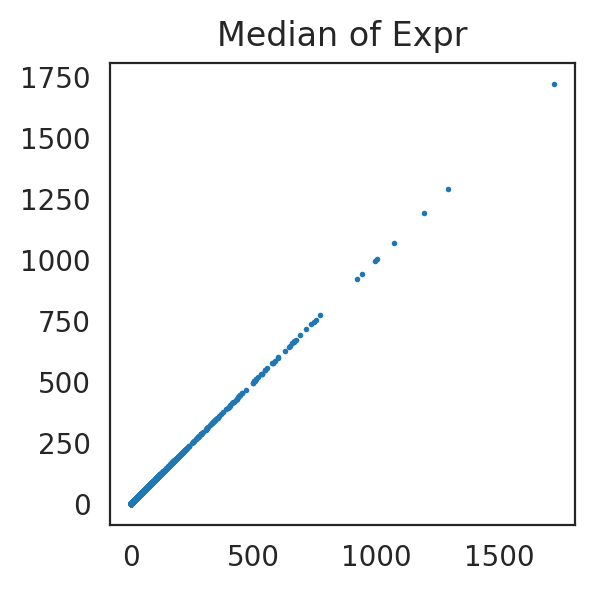

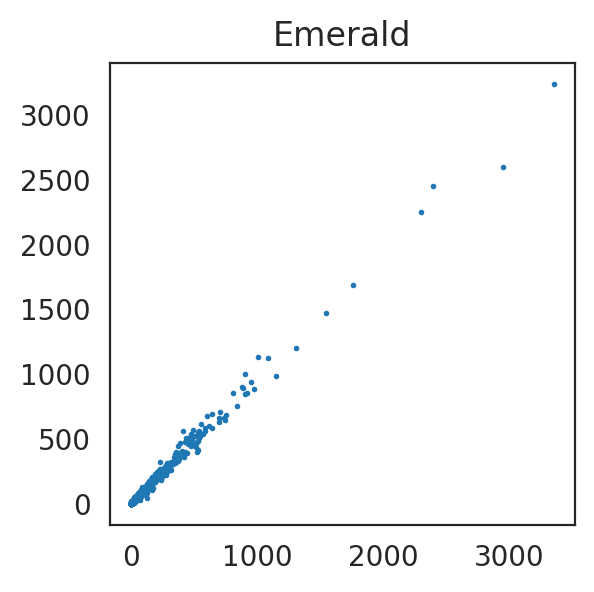

In [5]:
""" Two controls have identical expression levels except for 
genes that are missing in the microarrays. """
plt.figure(figsize=(3,3))
controlExpr = expression_quantified.X[expression_quantified.obs.perturbation == "Control" ,:]
controlExpr = controlExpr[:, ~(controlExpr[1,:] == -9999)]
plt.scatter(controlExpr[0,:], controlExpr[1,:], s=1)
plt.title("Median of Expr")
plt.show()

plt.figure(figsize=(3,3))
controlExpr = expression_quantified.X[expression_quantified.obs.perturbation == "Emerald" ,:]
controlExpr = controlExpr[:, ~(controlExpr[1,:] == -9999)]
plt.scatter(controlExpr[0,:], controlExpr[1,:], s=1)
plt.title("Emerald")
plt.show()

In [6]:
missing = expression_quantified.X==-9999
expression_quantified.obs["fraction_missing"] = missing.mean(axis=1)
expression_quantified.var["fraction_missing"] = missing.mean(axis=0)
controlIndex = expression_quantified.obs.index=="Control"
for i in range(len(expression_quantified.obs.index)):
    missing_i = np.squeeze(expression_quantified[i,:].X==-9999)
    expression_quantified.X[i,missing_i] = expression_quantified.X[controlIndex,missing_i]

In [7]:
display(pd.DataFrame(
    pd.DataFrame(
        expression_quantified.obs.fraction_missing.tolist(), 
        columns=["% Gene Missing"])
    .value_counts(), 
    columns=["Such # of Clones"]))

display(pd.DataFrame(
    pd.DataFrame(
        expression_quantified.var.fraction_missing.tolist(), 
        columns=["% Clone Missing"])
    .value_counts(), 
    columns=["Such # of Genes"]))

Such # of Clones
% Gene Missing                  
0.000000                     844
0.192786                     149
0.000040                       4
0.000159                       2
0.000239                       2
0.000279                       2
0.000080                       1
0.000120                       1
0.000359                       1
0.000917                       1
0.001993                       1
0.193105                       1
0.193224                       1
0.194739                       1
0.195496                       1

Such # of Genes
% Clone Missing                 
0.000000                   20032
0.151186                    4804
0.000988                     214
0.152174                      33
0.001976                       7

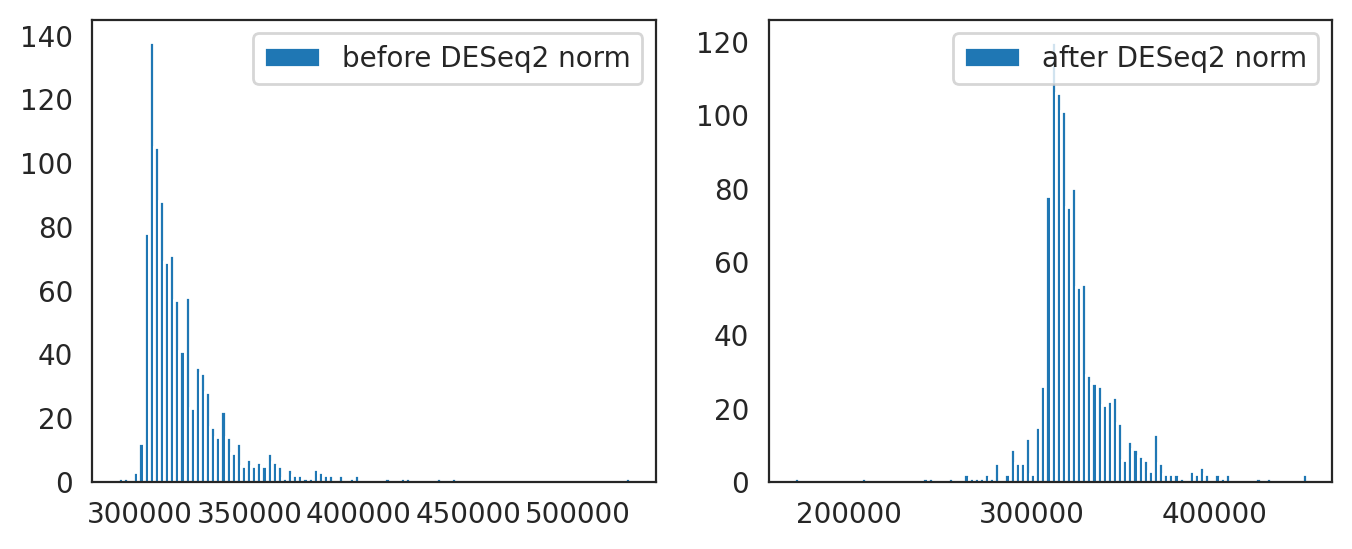

In [8]:
""" Sanity Check:
The sum of gene expression before and after normalization """
fig, axes = plt.subplots(1, 2, figsize=(8,3))
axes[0].hist(expression_quantified.X.sum(axis=1), bins=100, log=False, label="before DESeq2 norm")
axes[1].hist(ingestion.deseq2Normalization(expression_quantified.X.T).T.sum(axis=1), bins=100, log=False, label="after DESeq2 norm")
axes[0].legend()
axes[1].legend()
plt.show()

### Normalization on bulk 

In [9]:
expression_quantified.X = ingestion.deseq2Normalization(expression_quantified.X.T).T

### Check Gene Expr Consistency, Replication Consistency

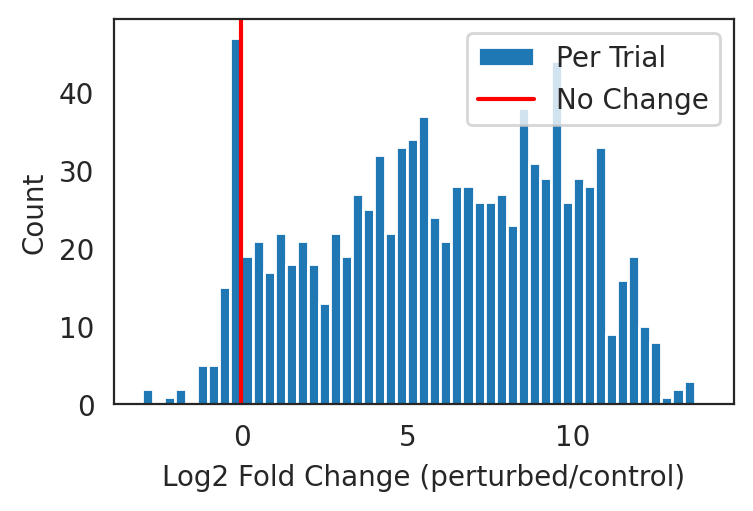

Counter({'Yes': 929, 'NA': 6, 'No': 77})

In [10]:
# If verbose is set to True, display disconcordant trials and their controls
status, logFC = ingestion.checkConsistency(expression_quantified, 
                                           perturbationType="overexpression", 
                                           group=None,
                                           verbose=False) 
expression_quantified.obs["consistentW/Perturbation"] = status
expression_quantified.obs["logFC"] = logFC
Counter(status)

In [11]:
TFqPCR = set(pd.read_csv(nakatakeSupplemental3Path)['TF'])
expression_quantified.obs['qPCRExamined'] = [True if i in TFqPCR else False for i in expression_quantified.obs.perturbation]

[0 1] AATF
[859 860] ALX1
[2 3] ALX3
[4 5] ALX4
[6 7] ANKRD22
[8 9] AR
[10 11] ARID3A
[861 862] ARID3B
[12 13] ARNT2
[14 15] ASCL1
[16 17] ASCL2
[18 19] ASH2L
[20 21] ATF1
[22 23] ATF2
[24 25] ATF3
[863 864] ATF4
[26 27] ATOH1
[28 29] BACH1
[30 31] BANP
[32 33] BARHL2
[34 35] BARX2
[36 37] BATF
[38 39] BATF3
[40 41] BCL6
[42 43] BHLHE40
[44 45] BLZF1
[865 866] BMI1
[867 868] BMP2
[46 47] BMP4
[869 870] BMP7
[871 872] BRF1
[48 49] BRF2
[51 52] CBX2
[874 875] CBX3
[53 54] CBX8
[55 56] CCNE1
[876 877] CDK9
[57 58 59] CDX2
[60 61] CDYL
[62 63] CDYL2
[64 65] CEBPA
[66 67] CEBPB
[68 69] CEBPD
[71 72] CERS2
[74 75] CHD4
[878 879] CHD5
[880 881] CITED1
[76 77] CREB1
[78 79] CREB3
[80 81] CRY1
[82 83] CRY2
[882 883] CTBP1
[84 85] CTBP2
[87 88] CTCFL
[89 90] CTNNB1
[91 92] CUX1
[884 885] CXXC5
[886 887] DBX1
[888 889] DBX2
[93 94] DEDD2
[95 96] DLX2
[97 98] DLX3
[ 99 100] DLX4
[101 102] DLX5
[103 104] DLX6
[105 106] DMRT1
[890 891] DMRT2
[107 108] DMRTC2
[109 110] DNMT3L
[112 113] DVL2
[114 115]

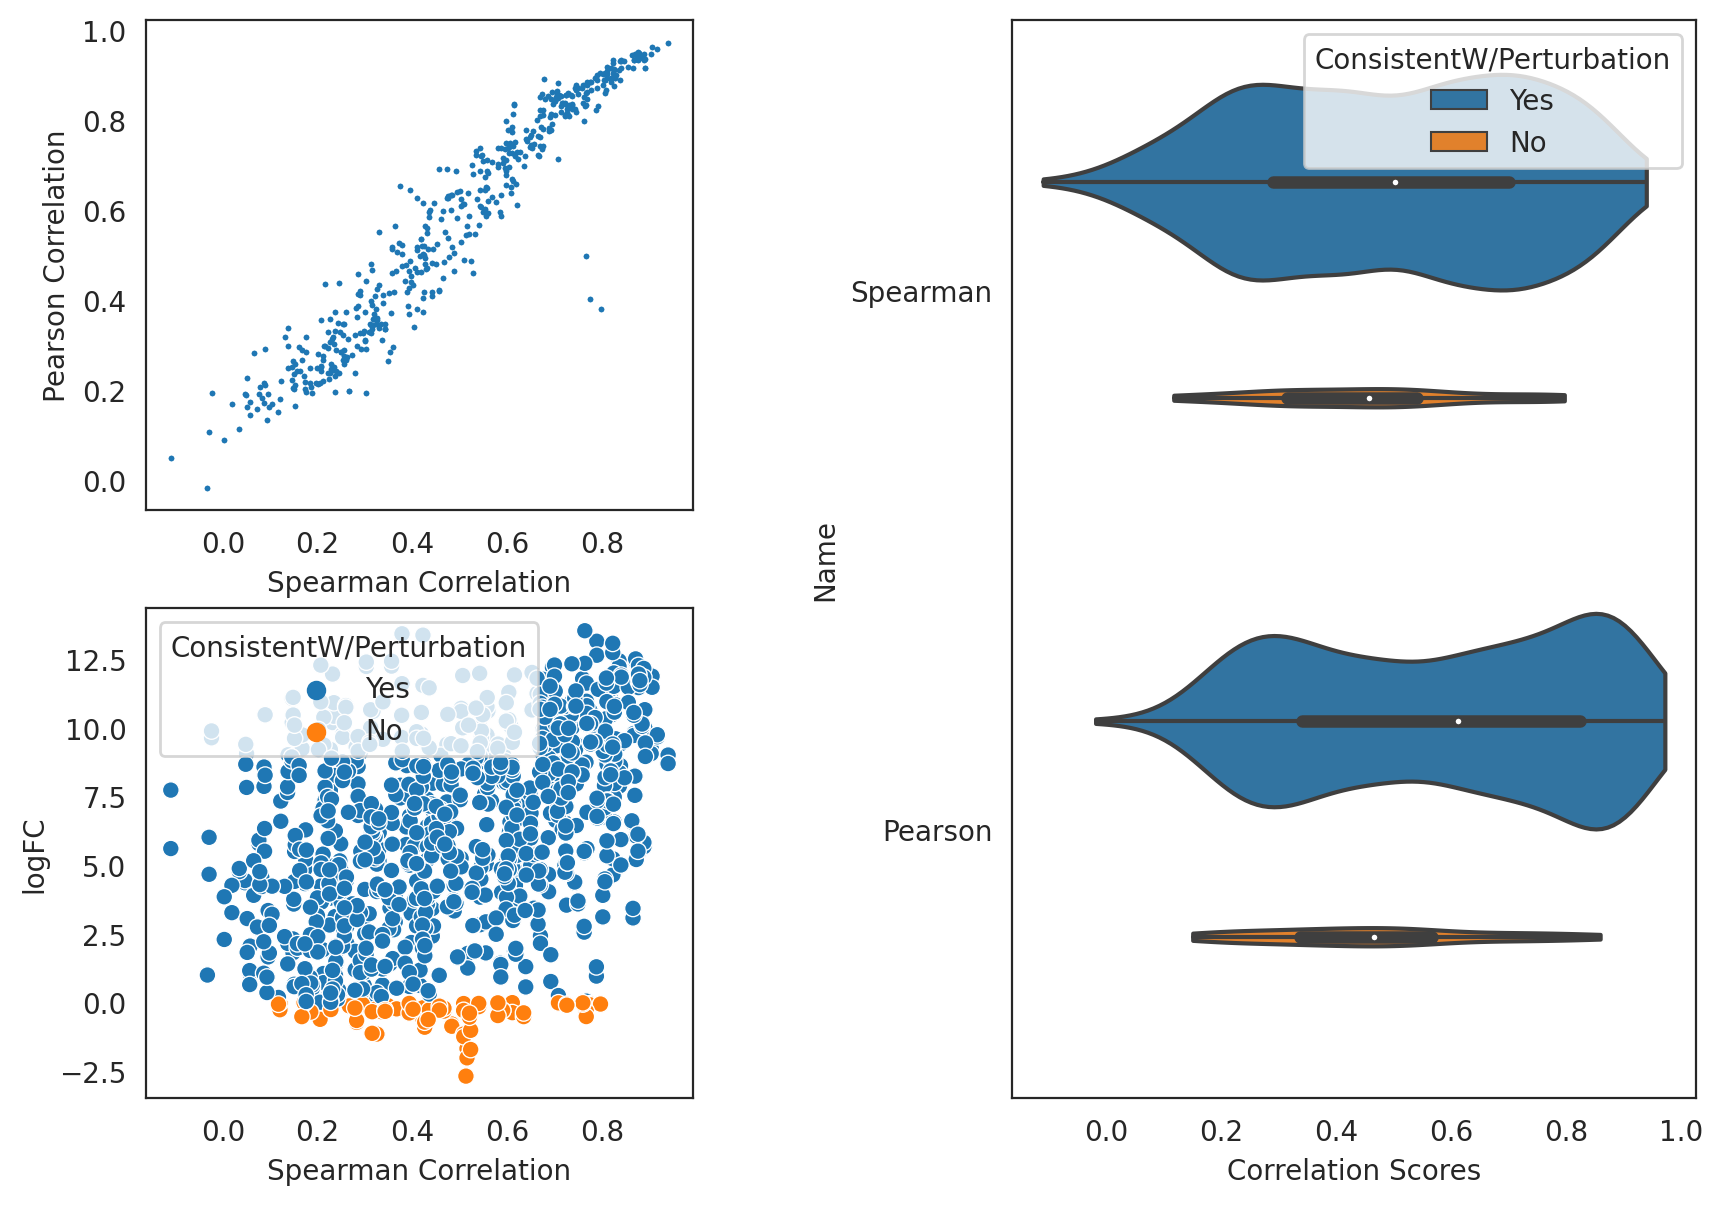

In [12]:
correlations = ingestion.computeCorrelation(expression_quantified, verbose=True)
expression_quantified.obs["spearmanCorr"] = correlations[0]
expression_quantified.obs[ "pearsonCorr"] = correlations[1]

In [13]:
"""
Downloaded from http://humantfs.ccbr.utoronto.ca/download.php """
TFList = pd.read_csv(humanTFPath, index_col=0).iloc[:, [1,3]]
TFDict = dict([tuple(i) for i in TFList.to_numpy().tolist() if i[1] == 'Yes'])

"""
Downloaded from https://epifactors.autosome.org/description """
EpiList = pd.read_csv(humanEpiPath, index_col=0).iloc[:, [0,14]]
EpiDict = dict([tuple(i) for i in EpiList.to_numpy().tolist()])

"""
Download from https://ars.els-cdn.com/content/image/1-s2.0-S2211124720306082-mmc2.xlsx """
annotation = pd.read_csv(nakatakeSupplemental1Path).iloc[:, [0,1]]
annotation = dict([tuple(i) for i in annotation.to_numpy().tolist()])

In [14]:
""" If want to look at effect magnitude of perturbation on TF only """
TFVar = [i for i,p in enumerate(expression_quantified.var.index) if p in TFDict or p in EpiDict]
expression_quantifiedTFOnly = expression_quantified[:, TFVar].copy()
ingestion.quantifyEffect(adata=expression_quantifiedTFOnly, 
                         fname=perturbEffectTFOnlyPath, 
                         group=None, 
                         diffExprFC=True, 
                         prefix="TFOnly")

2269
0 AATF 0.0 0.1318429410457611 0.09615082293748856 8.652923583984375 2.4561354890497036
1 ALX1 226.0 0.6082062125205994 0.3607211709022522 50.76638412475586 1.5411282858941142
2 ALX3 100.0 0.5531178712844849 0.3780113458633423 41.427833557128906 1.5384222738388207
3 ALX4 14.0 0.3876490592956543 0.26359859108924866 28.94476318359375 1.7523494162718651
4 ANKRD22 0.0 0.09129471331834793 0.05801208317279816 6.850810527801514 2.4307244509766646
5 AR 0.0 0.1124146431684494 0.08176209032535553 9.102445602416992 2.4379193045750105
6 ARID3A 4.0 0.16757996380329132 0.10762917250394821 13.446318626403809 2.1898083922482194
7 ARID3B 17.0 0.273094117641449 0.18668901920318604 18.924659729003906 1.9102545528178014
8 ARNT2 9.0 0.33058130741119385 0.1811719536781311 28.76527976989746 1.8876952017838549
9 ASCL1 278.0 0.6296179890632629 0.37733668088912964 49.25135803222656 1.4782452298201891
10 ASCL2 28.0 0.2880449593067169 0.16162124276161194 24.711261749267578 1.904401495222949
11 ASH2L 1.0 0.116

In [15]:
""" If want to look at effect magnitude of perturbation on the entire transcriptome """
ingestion.quantifyEffect(adata=expression_quantified, 
                         fname=perturbEffectFullTranscriptomePath, 
                         group=None, 
                         diffExprFC=True, 
                         prefix="")

listOfMetrics = ["DEG", "MI", "logFCMean", "logFCNorm2", "logFCMedian"]
for m in listOfMetrics:
    expression_quantified.obs[f"TFOnly{m}"] = expression_quantifiedTFOnly.obs[f"TFOnly{m}"]

25090
0 AATF 0.0 0.12441819161176682 0.06551897525787354 30.50934600830078 2.086841041400416
1 ALX1 1681.0 0.45250433683395386 0.26079094409942627 121.00269317626953 1.3613305583141417
2 ALX3 859.0 0.4425143301486969 0.23865169286727905 115.53634643554688 1.1860976878408285
3 ALX4 68.0 0.31314921379089355 0.17681193351745605 80.67985534667969 1.4214346210180457
4 ANKRD22 1.0 0.09535873681306839 0.04387417808175087 28.625329971313477 2.0498104053423343
5 AR 0.0 0.1041378453373909 0.05055208504199982 27.992351531982422 2.0561099945169947
6 ARID3A 28.0 0.14603646099567413 0.07344990968704224 40.40709686279297 1.86483570818736
7 ARID3B 191.0 0.24732260406017303 0.1566479206085205 60.92754364013672 1.6692548397155305
8 ARNT2 44.0 0.2327410727739334 0.10565933585166931 67.26651000976562 1.6198569224800357
9 ASCL1 2944.0 0.5724267959594727 0.2853483557701111 154.0267791748047 1.0112809509632892
10 ASCL2 152.0 0.24819637835025787 0.11460606753826141 74.03884887695312 1.5471975619722804
11 ASH2

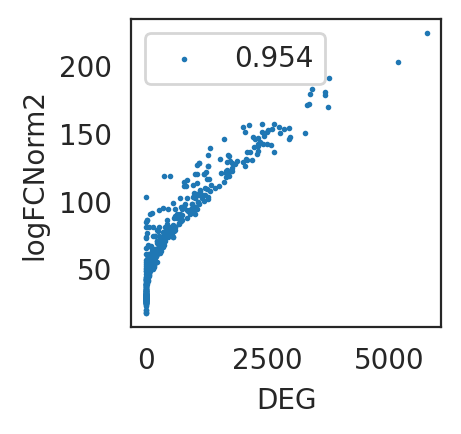

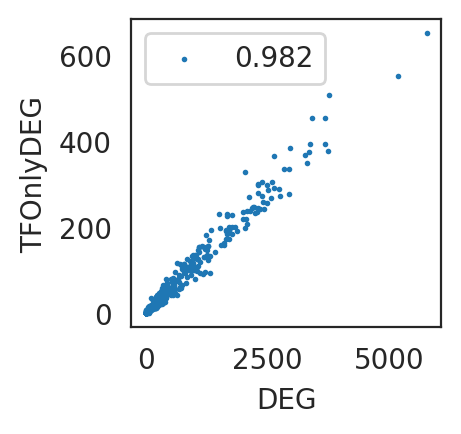

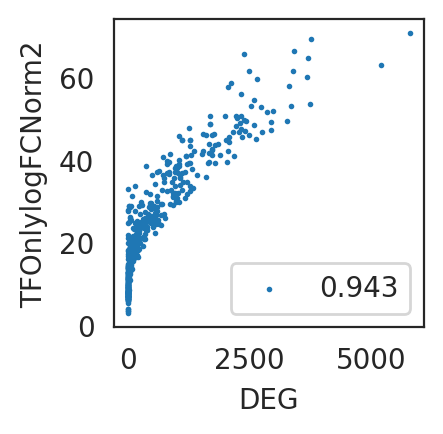

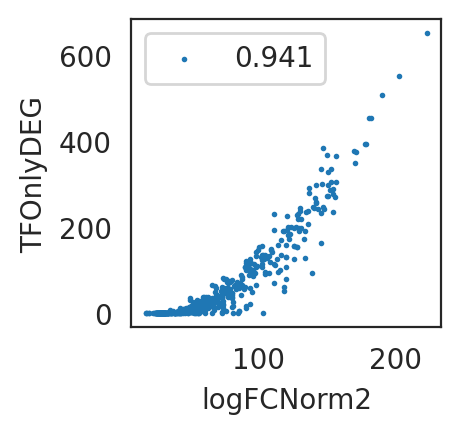

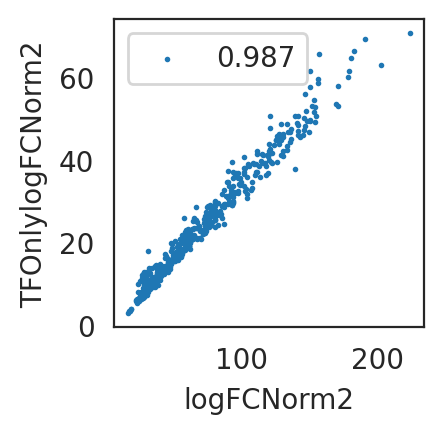

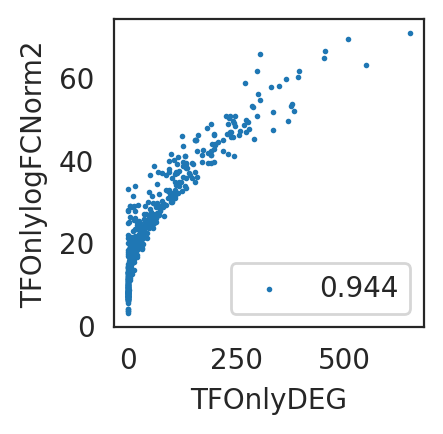

In [16]:
metricOfInterest = ["DEG", "logFCNorm2", "TFOnlyDEG", "TFOnlylogFCNorm2"]
ingestion.checkPerturbationEffectMetricCorrelation(expression_quantified, metrics=metricOfInterest)

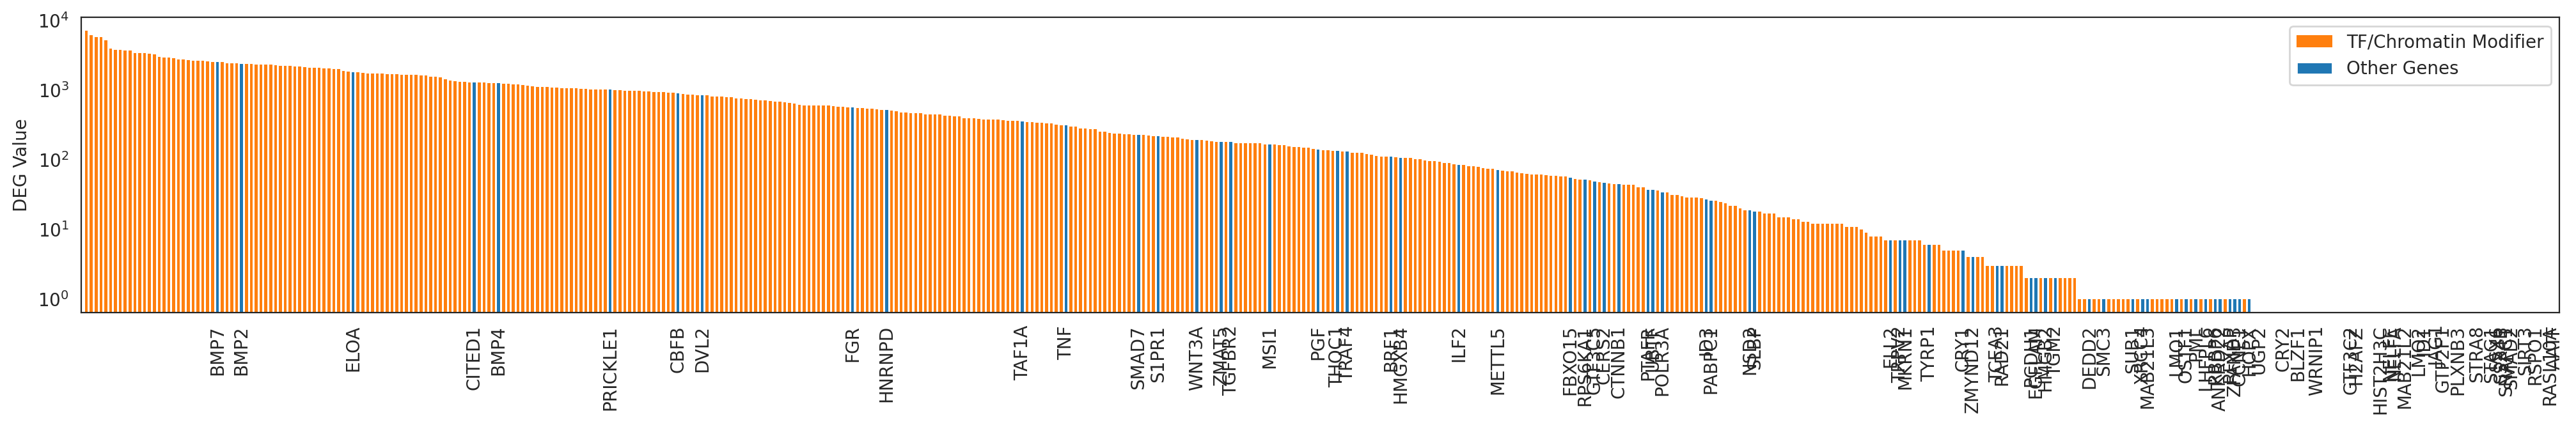

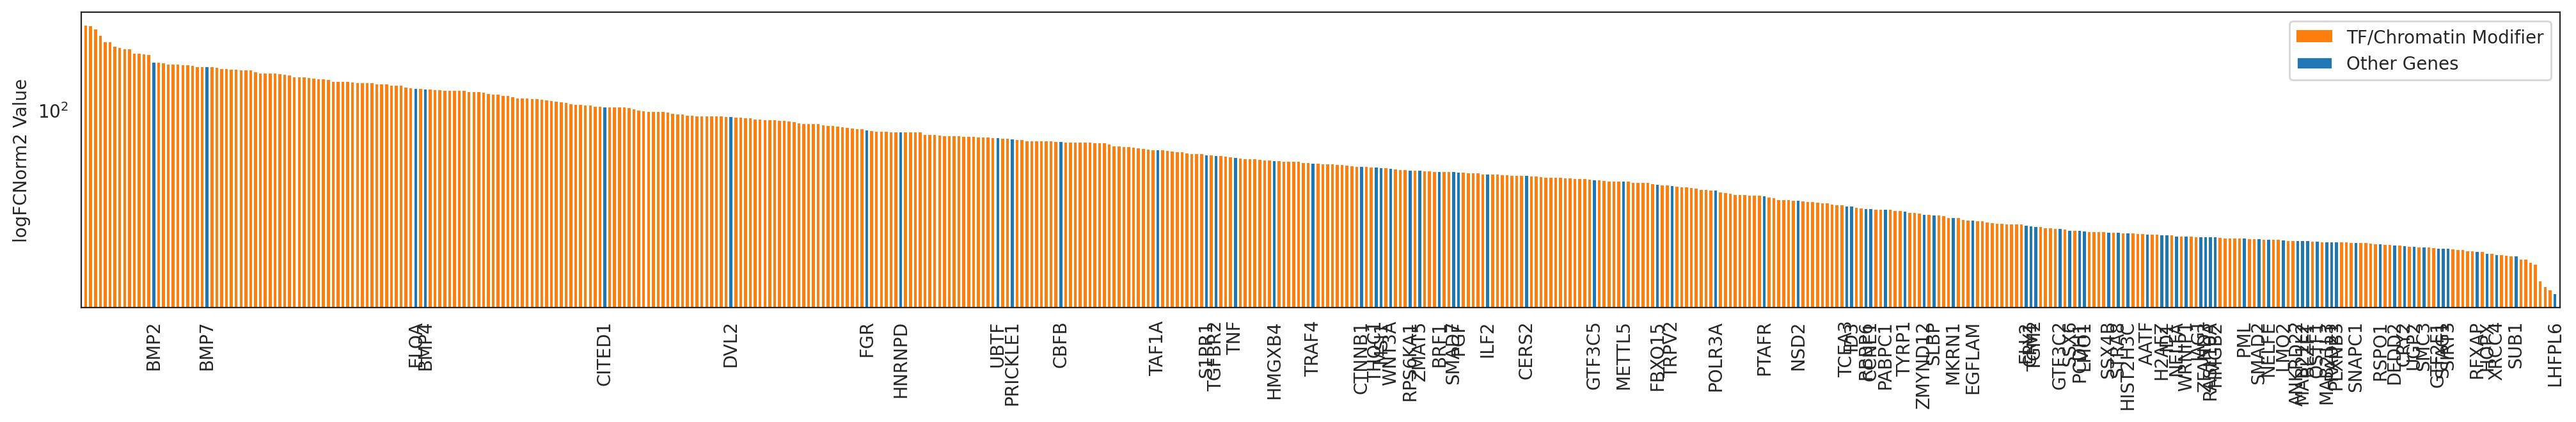

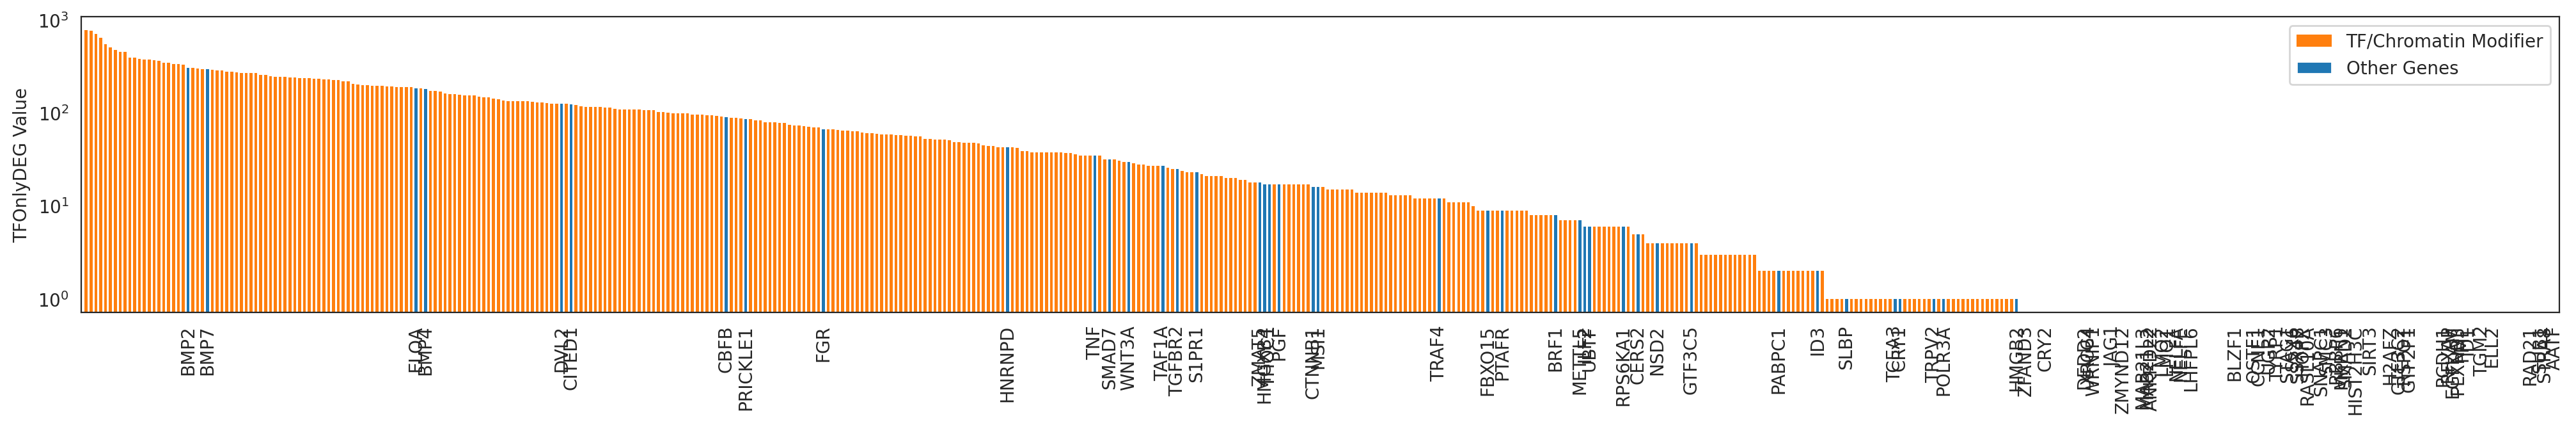

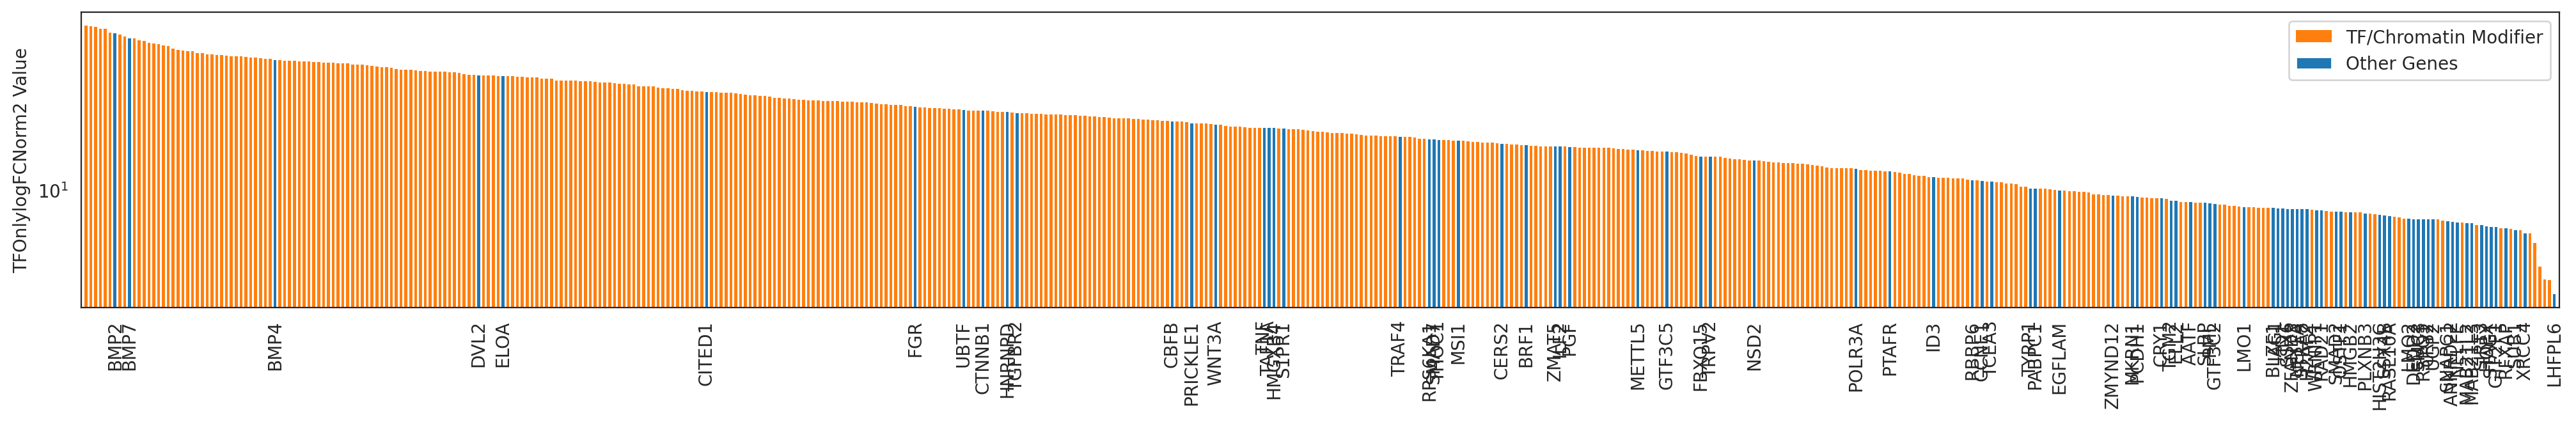

In [17]:
ingestion.visualizePerturbationEffect(expression_quantified, metrics=metricOfInterest, TFDict=TFDict, EpiDict=EpiDict)

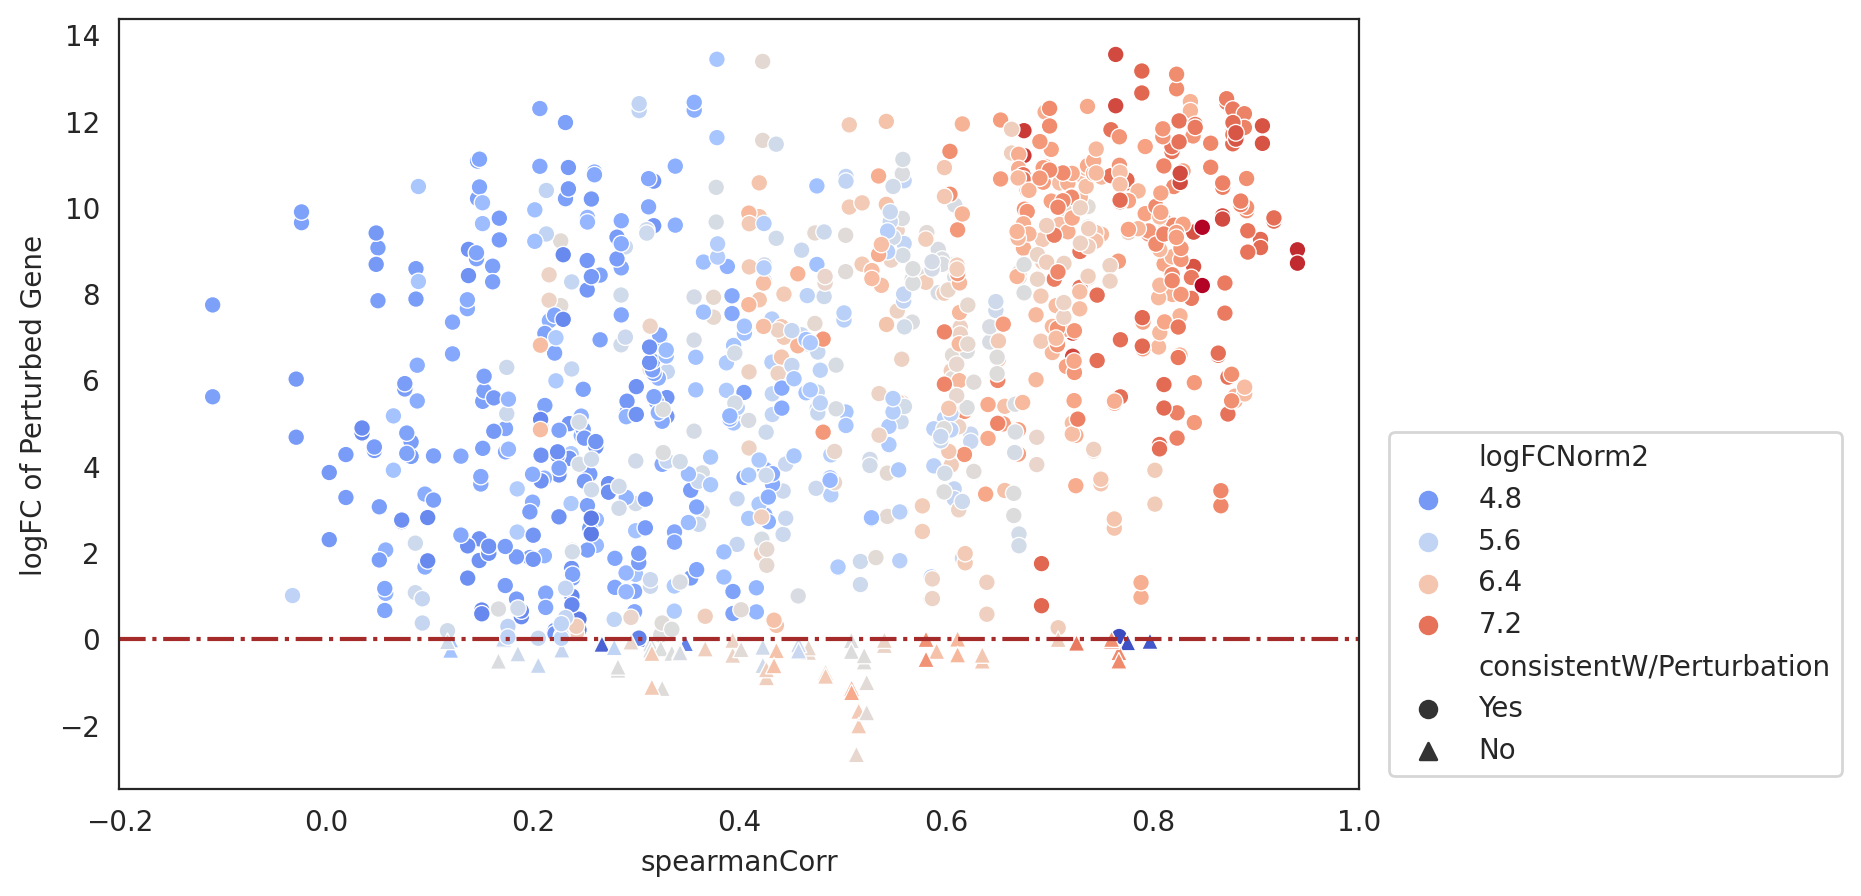

In [18]:
temp = expression_quantified.copy()

""" If you wish to see the magnitude of perturbation effect more clearer,
    i.e. a smoother gradient of the color shift, feel free to uncomment
    the line below, which takes the log of the norm2 """
temp.obs['logFCNorm2'] = np.log2(temp.obs['logFCNorm2'])

ingestion.visualizePerturbationMetadata(temp,
                                        x="spearmanCorr", 
                                        y="logFC", 
                                        style="consistentW/Perturbation", 
                                        hue="logFCNorm2", 
                                        markers=['o', '^'], 
                                        xlim=[-0.2, 1])

### Basic EDA

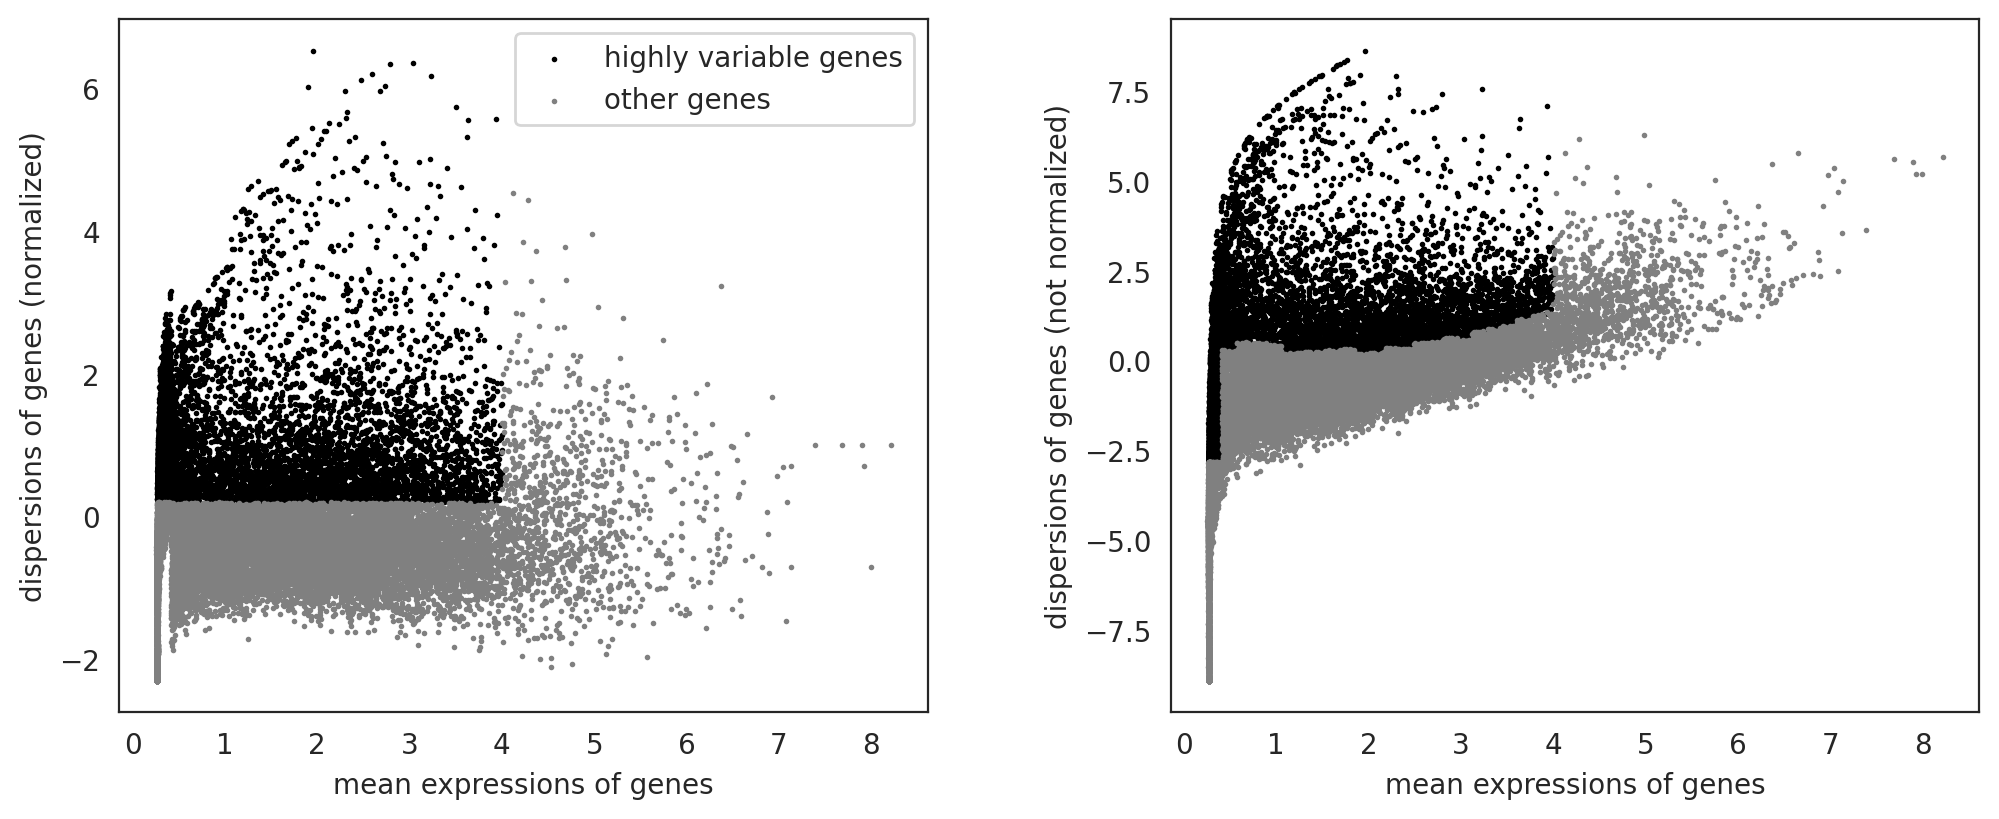

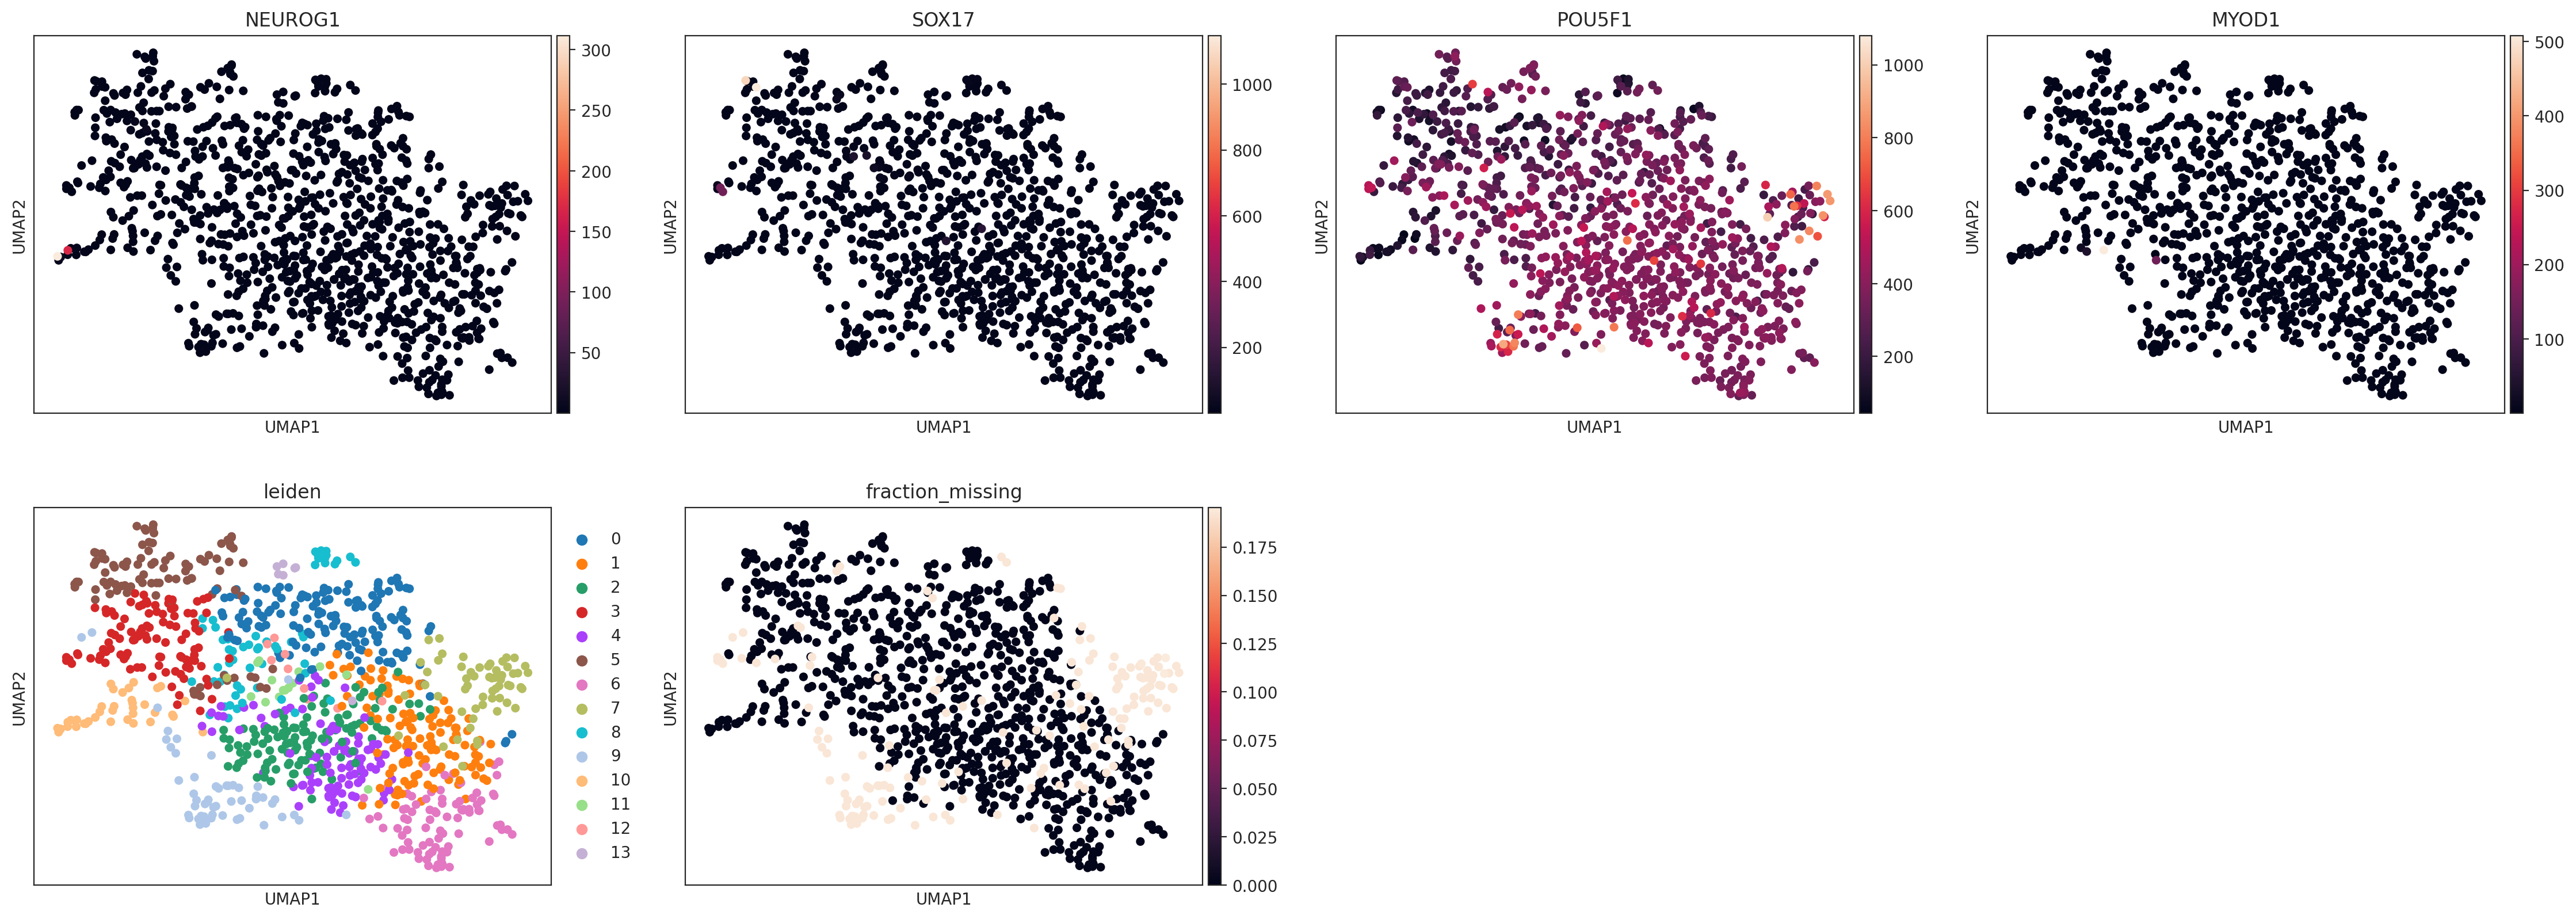

In [19]:
# sc.pp.normalize_total(expression_quantified, target_sum=1e4)
sc.pp.log1p(expression_quantified)
sc.pp.highly_variable_genes(expression_quantified, min_mean=0.2, max_mean=4, min_disp=0.2, n_bins=50)
sc.pl.highly_variable_genes(expression_quantified)
with warnings.catch_warnings():
    sc.tl.pca(expression_quantified, n_comps=100)
sc.pp.neighbors(expression_quantified)
sc.tl.umap(expression_quantified)
clusterResolutions = []
sc.tl.leiden(expression_quantified)
sc.pl.umap(expression_quantified, color = ["NEUROG1", "SOX17", "POU5F1", "MYOD1", "leiden", "fraction_missing"])
# Due to the small number of samples, ask CO to use only one cluster.
# Requires setting certain other undocumented aspects of object state. :(
expression_quantified.obs["fake_cluster"] = "all_one_cluster"
expression_quantified.obs.fake_cluster = expression_quantified.obs.fake_cluster.astype("category")
expression_quantified.uns["fake_cluster_colors"] = ['#1f77b4']

### Data reduction

With only 64GB of RAM, I have been unable to make whole-transcriptome predictions with CellOracle. A data reduction step is necessary where only highly variable genes are included. We also keep all genes that are perturbed, whether or not they appear highly variable -- unless they are unavailable in the first place. 

For quick software tests, we also take some data with as few genes as possible (just those that are perturbed and measured).

In [20]:
perturbed_genes = set(list(expression_quantified.obs['perturbation'].unique())).difference(controls)
perturbed_and_measured_genes = perturbed_genes.intersection(expression_quantified.var.index)
perturbed_but_not_measured_genes = perturbed_genes.difference(expression_quantified.var.index)
print("These genes were perturbed but not measured:")
print(perturbed_but_not_measured_genes)
genes_keep = expression_quantified.var.index[expression_quantified.var['highly_variable']]
genes_keep = set(genes_keep).union(perturbed_and_measured_genes)
expression_quantified_orig = expression_quantified
# Nakatake data final form
expression_quantified = expression_quantified_orig[:,list(genes_keep)]
expression_quantified.uns["perturbed_and_measured_genes"] = list(perturbed_and_measured_genes)
expression_quantified.uns["perturbed_but_not_measured_genes"] = list(perturbed_but_not_measured_genes)

expression_quantified = ingestion.describe_perturbation_effect(expression_quantified, "overexpression")

These genes were perturbed but not measured:
{'DUX4'}


### Final QC Conclusion

In [21]:
""" Remove everything that is below the logFC < 0 line """

expression_quantified = expression_quantified[expression_quantified.obs.logFC > 0,:].copy()

In [22]:
try:
    os.makedirs(finalDataFileFolder)
except FileExistsError:
    pass
expression_quantified.write_h5ad(finalDataFilePath)